<a href="https://colab.research.google.com/github/MaxMaffio/InterviewQuery/blob/main/Capgemini_Sale_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Capgemini](https://raw.githubusercontent.com/interviewquery/takehomes/capgemini_3/capgemini_3/logo.png)
# Purpose

The team has asked that you prepare a 20 to 30-minute presentation (in this notebook) on one of the topics from below. The purpose of this
exercise is to demonstrate your ability to draw insights from data, put
insights in business-friendly format and confirm coding knowledge. These
topics are similar in nature to projects we run. Please make sure that
your presentation is accessible to a general technical audience (aside from the sections of code, of course).


# Data


**Sales Forecasting**

Build and evaluate models to predict national retail store sales for
each store and department. Our sales are very seasonal, and we make
our money during holidays like Super Bowl, Labor Day, Thanksgiving,
and Christmas. The data is contained in `sales_forcasting.csv`

# Deliverables
Your notebook should contain:

1.  Description of the problem; state what you are solving/ analyzing
2.  Presentation of insights/conclusion you generate
3.  Relevant descriptive statistics (charts, graphs, etc.)
4.  Specification of predictive model (mathematical formulation)
5.  Relevant model diagnostics
6.  Model interpretation (what do the coefficients mean, how do you use
    them?)
7.  Please specify language, packages and libraries used to develop your
    solution

# Evaluation Criteria

- Presentation on analysis conducted that covers business outcomes and statistical methodologies
- Preform exploratory data analysis to gather starting insights and conclusions
- Selection of ML/Predictive modeling technique(s) & feature extraction
- Knowledge with data ingestion tools/languages
- Ability to conduct appropriate data cleansing if any
- Ability to code in open source languages

# Rules

- Use any open source language of your choice

- Solution you provide should be your own. Reference any material desired.

- Be prepared to discuss your code in-depth (what it does, how it does it etc.)

- Utilize any statistical or ML technique(s) you deem relevant. For
each technique that you use, be prepared to talk about model
diagnostics, results, and mathematics behind your technique(s).

- No time limit on developing your solution. Let us know when you are ready.


In [ ]:
!git clone --branch capgemini_3 https://github.com/interviewquery/takehomes.git
%cd takehomes/capgemini_3
!ls

Cloning into 'takehomes'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (1963/1963), done.
remote: Compressing objects: 100% (1220/1220), done.
remote: Total 1963 (delta 752), reused 1927 (delta 726), pack-reused 0 (from 0)
Receiving objects: 100% (1963/1963), 297.43 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/takehomes/capgemini_3
logo.png  metadata.json  sales_forecasting.csv	takehomefile.ipynb


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import cv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller Test
import statsmodels.api as sma
import itertools
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
# Suppress warnings for cleaner output
warnings.simplefilter('ignore', ConvergenceWarning)

# READ DATA

In [ ]:
# read data
df = pd.read_csv("sales_forecasting.csv")

# print
print(df.shape)
df.head()

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


# EXPLORATIVE ANALYSIS

## missing values

In [ ]:
# checking for missing values in each columns
for str_col in df.columns.tolist():
  n_nan = df["IsHoliday"].isna().sum()
  print(str_col + " has NaN values: " + str(n_nan))

Store has NaN values: 0
Dept has NaN values: 0
Date has NaN values: 0
Weekly_Sales has NaN values: 0
IsHoliday has NaN values: 0


## general overview

In [ ]:
# general overview
d_dict_formula = {"Dept":"nunique",
                  "Date":["min", "max"],
                  "Weekly_Sales":["min", "mean", "max", "std"]
                  }
df.groupby(["Store"], as_index=False).agg(d_dict_formula)

Store    Dept        Date             Weekly_Sales                \
         nunique         min         max          min          mean   
0      1      77  2010-02-05  2012-10-26      -863.00  21710.543621   
1      2      78  2010-02-05  2012-10-26     -1098.00  26898.070031   
2      3      72  2010-02-05  2012-10-26     -1008.96   6373.033983   
3      4      78  2010-02-05  2012-10-26      -898.00  29161.210415   
4      5      72  2010-02-05  2012-10-26      -101.26   5053.415813   
5      6      77  2010-02-05  2012-10-26      -698.00  21913.243624   
6      7      76  2010-02-05  2012-10-26      -459.00   8358.766148   
7      8      76  2010-02-05  2012-10-26      -100.00  13133.014768   
8      9      73  2010-02-05  2012-10-26      -496.00   8772.890379   
9     10      77  2010-02-05  2012-10-26      -798.00  26332.303819   
10    11      78  2010-02-05  2012-10-26      -594.00  19276.762751   
11    12      75  2010-02-05  2012-10-26      -598.00  14867.308619   
12    13      79  2010-02-05  2012-10-26       -98.00  27355.136891   
13    14      77  2010-02-05  2012-10-26      -498.00  28784.851727   
14    15      79  2010-02-05  2012-10-26      -179.00   9002.493073   
15    16      76  2010-02-05  2012-10-26     -1699.00   7863.224124   
16    17      76  2010-02-05  2012-10-26      -259.00  12954.393636   
17    18      78  2010-02-05  2012-10-26      -259.00  15733.313136   
18    19      79  2010-02-05  2012-10-26      -649.00  20362.126734   
19    20      78  2010-02-05  2012-10-26      -798.00  29508.301592   
20    21      77  2010-02-05  2012-10-26      -450.00  11283.435496   
21    22      76  2010-02-05  2012-10-26      -175.54  15181.218886   
22    23      77  2010-02-05  2012-10-26      -298.00  19776.180881   
23    24      77  2010-02-05  2012-10-26      -109.00  18969.106500   
24    25      77  2010-02-05  2012-10-26       -99.87  10308.157810   
25    26      76  2010-02-05  2012-10-26       -79.00  14554.129672   
26    27      78  2010-02-05  2012-10-26      -409.00  24826.984536   
27    28      77  2010-02-05  2012-10-26     -4988.94  18714.889803   
28    29      77  2010-02-05  2012-10-26      -300.00   8158.810609   
29    30      64  2010-02-05  2012-10-26       -26.61   8764.237719   
30    31      76  2010-02-05  2012-10-26      -224.00  19681.907464   
31    32      77  2010-02-05  2012-10-26      -698.00  16351.621855   
32    33      63  2010-02-05  2012-10-26       -39.76   5728.414053   
33    34      78  2010-02-05  2012-10-26      -598.00  13522.081671   
34    35      74  2010-02-05  2012-10-26     -3924.00  13803.596986   
35    36      63  2010-02-05  2012-10-26      -419.28   8584.412563   
36    37      62  2010-02-05  2012-10-26       -64.38  10297.355026   
37    38      63  2010-02-05  2012-10-26      -153.12   7492.478460   
38    39      75  2010-02-05  2012-10-26      -159.00  21000.763562   
39    40      77  2010-02-05  2012-10-26      -543.00  13763.632803   
40    41      77  2010-02-05  2012-10-26      -279.00  17976.004648   
41    42      62  2010-02-05  2012-10-26      -379.00  11443.370118   
42    43      61  2010-02-05  2012-10-26      -372.90  13415.114118   
43    44      62  2010-02-05  2012-10-26      -132.46   6038.929814   
44    45      74  2010-02-05  2012-10-26     -1750.00  11662.897315   

                             
          max           std  
0   203670.47  27748.945511  
1   285353.53  33077.612059  
2   155897.94  14251.034807  
3   385051.04  34583.677814  
4    93517.72   8068.221050  
5   342578.65  23633.427075  
6   222921.09  10679.008085  
7   153431.69  15132.069598  
8   139427.43  12446.502614  
9   693099.36  32133.006264  
10  245767.47  20391.897907  
11  360140.66  17967.248878  
12  292165.78  33853.474638  
13  474330.10  36911.116744  
14  292555.25  11362.009143  
15  129372.97  10491.369269  
16  194660.52  16299.024131  
17  353008.64  18556.351564  
18  339846.03  24281.125431  
19  422306.25  35661.530620  
20  2

## store

In [ ]:
# general overview of the ts per each store
fig = go.Figure()
# ts for each store
for n_store in df['Store'].unique():
  df_store = df[df['Store'] == n_store].groupby(["Store", "Date"], as_index=False).agg({"Weekly_Sales":"mean"}).sort_values("Date")
  x_axis = df_store["Date"].unique()
  y_axis = df_store["Weekly_Sales"].tolist()
  data = go.Scatter(x=x_axis,
                    y=y_axis,
                    name=f"Store {n_store}"
                    )
  fig.add_trace(data)
  fig.update_layout(title=dict(text='weekly_sales avg for each store'))
# print
fig.show()

## dept

In [ ]:
# general overview of the ts per each department
fig = go.Figure()
# ts for each store
for n_store in df['Dept'].unique():
  df_store = df[df['Dept'] == n_store].groupby(["Dept", "Date"], as_index=False).agg({"Weekly_Sales":"mean"}).sort_values("Date")
  x_axis = df_store["Date"].unique()
  y_axis = df_store["Weekly_Sales"].tolist()
  data = go.Scatter(x=x_axis,
                    y=y_axis,
                    name=f"Dept {n_store}"
                    )
  fig.add_trace(data)
  fig.update_layout(title=dict(text='weekly_sales avg for each department'))
# print
fig.show()

## holidays

In [ ]:
# dataframe with holidays
df["d_is_holiday"] = np.where(df["IsHoliday"]==True,1,0)
df_holidays = pd.DataFrame({"Date":sorted(df.loc[df["d_is_holiday"]==1,"Date"].unique())})
df_holidays.reset_index(drop=False, inplace=True)
df_holidays["index"] = df_holidays["index"] + 1

# dataframe with days
df_dates = pd.DataFrame({"Date":sorted(df["Date"].unique())})
# merge
df_dates = df_dates.merge(df_holidays, on="Date", how="left")
df_dates["d_is_holiday"] = np.where(df_dates["Date"].isin(df_holidays["Date"]), df_dates["index"],np.nan)
df_dates["str_is_holiday"] = np.where(df_dates["d_is_holiday"].isna()==False, df_dates["Date"], "")

In [ ]:
# general overview of the ts per each department
fig = go.Figure()
x_axis = df_dates["Date"].unique()
y_axis = df_dates["index"].tolist()
data = go.Scatter(x=x_axis,
                  y=y_axis,
                  name="Holidays",
                  mode="markers+text",
                  text=df_dates["str_is_holiday"],
                  textposition="bottom center"
                  )
fig.add_trace(data)
fig.update_layout(title=dict(text='Holidays'))
# print
fig.show()

# MODEL

The analysis focuses on the weekly sales of the stores. This reason is gven by these factors:

* each store has its own characteristics (location, type of customers,...)
* store are more manageble, as they count only 45
* some stores has much less departments than other stores
* the departments are strictly dependent on the stores and we do not know if department 1 contains the same products for all the stores

Thus, I start by grouping the stores and summing up their weekly sales, in order to obtain a weekly time series of sales per each store.

In [ ]:
# prepare the dataframe, group by stores and date and summ up the weekly sales
df_stores_sales = df.groupby(["Store", "Date"], as_index=False).agg({"Weekly_Sales":"sum"})
# print
df_stores_sales.head()

,Store,Date,Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


## adfuller test

Perform ADFuller Test to check for Non Stationarity

In [ ]:
## -----------------------------------------------------------------------------
# function to perform the ADFULLER TEST in the time series
def adfuller_test(series,  n_reg, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC', regression=n_reg)
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    # print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    # print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    # print(f' Significance Level    = {signif}')
    # print(f' Test Statistic        = {output["test_statistic"]}')
    # print(f' No. Lags Chosen       = {output["n_lags"]}')

    # for key,val in r[4].items():
    #     print(f' Critical value {adjust(key)} = {round(val, 3)}')

    # if p_value <= signif:
    #     print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    #     print(f" => Series is Stationary.")
    # else:
    #     print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    #     print(f" => Series is Non-Stationary.")
    return pd.DataFrame({"Store":[name],
                         "Significance Level":[signif],
                         "Test Statistic":[output["test_statistic"]],
                         "No. Lags Chosen":[output["n_lags"]],
                         "p-value":[p_value],
                         "Critical Value 1%":[r[4]["1%"]],
                         "Critical Value 5%":[r[4]["5%"]],
                         "Critical Value 10%":[r[4]["10%"]],
                         "Reject Null Hypothesis":[p_value<=signif]
                         })
## -----------------------------------------------------------------------------

In [ ]:
# Run the ADFULLER TEST on each ts of Weekly Sales
# preallocate the output
df_adfuller = pd.DataFrame()
# ADF Test on each store
for str_var in df_stores_sales["Store"].unique().tolist():
  cond_1 = df_stores_sales["Store"] == str_var
  df_output = adfuller_test(df_stores_sales.loc[cond_1, "Weekly_Sales"].tolist(), name=str_var, n_reg='c')
  df_adfuller = pd.concat([df_adfuller, df_output])
  #print('\n')
 # print output
print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
df_adfuller

 Null Hypothesis: Data has unit root. Non-Stationary.


,Store,Significance Level,Test Statistic,No. Lags Chosen,p-value,Critical Value 1%,Critical Value 5%,Critical Value 10%,Reject Null Hypothesis
0,1,0.05,-5.1022,4,0.0000,-3.478648,-2.882722,-2.578065,True
0,2,0.05,-3.7089,6,0.0040,-3.479372,-2.883037,-2.578234,True
0,3,0.05,-2.9639,6,0.0384,-3.479372,-2.883037,-2.578234,True
0,4,0.05,-2.8794,6,0.0478,-3.479372,-2.883037,-2.578234,True
0,5,0.05,-4.3110,4,0.0004,-3.478648,-2.882722,-2.578065,True
0,6,0.05,-5.4925,4,0.0000,-3.478648,-2.882722,-2.578065,True
0,7,0.05,-4.4763,7,0.0002,-3.479743,-2.883198,-2.578320,True
0,8,0.05,-5.6477,4,0.0000,-3.478648,-2.882722,-2.578065,True
0,9,0.05,-5.0086,4,0.0000,-3.478648,-2.882722,-2.578065,True
0,10,0.05,-5.2007,4,0.0000,-3.478648,-2.882722,-2.578065,True


## stationarize

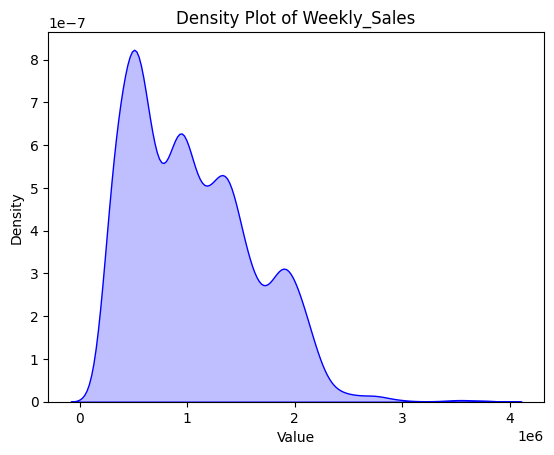

In [ ]:
# plot density of delivery_duration_seconds
# Create the density plot
sns.kdeplot(df_stores_sales["Weekly_Sales"], fill=True, color="blue", bw_adjust=1)  # `fill=True` for a shaded plot

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Weekly_Sales')
plt.show()

In [ ]:
# prompt: create a new column in df_stores_sales obtained as the log difference of each observation with the lagged one, in order to stationarize the time seires

# Calculate the log difference of 'Weekly_Sales'
#df_stores_sales['Weekly_Sales_Diff'] = (df_stores_sales['Weekly_Sales'] / df_stores_sales['Weekly_Sales'].shift(1)) -1
#df_stores_sales['Weekly_Sales_Diff'] = np.log(df_stores_sales['Weekly_Sales']) - np.log(df_stores_sales['Weekly_Sales'].shift(1))
df_stores_sales['Weekly_Sales_Diff'] = df_stores_sales['Weekly_Sales'] - df_stores_sales['Weekly_Sales'].shift(1)
# print
df_stores_sales.head()

,Store,Date,Weekly_Sales,Weekly_Sales_Diff
0,1,2010-02-05,1643690.90,NaN
1,1,2010-02-12,1641957.44,-1733.46
2,1,2010-02-19,1611968.17,-29989.27
3,1,2010-02-26,1409727.59,-202240.58
4,1,2010-03-05,1554806.68,145079.09


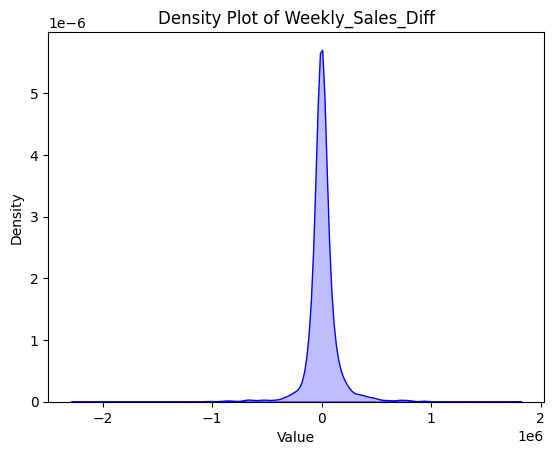

In [ ]:
# plot density of delivery_duration_seconds
# Create the density plot
sns.kdeplot(df_stores_sales["Weekly_Sales_Diff"], fill=True, color="blue", bw_adjust=1)  # `fill=True` for a shaded plot

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Weekly_Sales_Diff')
plt.show()

In [ ]:
# skewnes and kurtosis
# Define a custom kurtosis function for Pandas compatibility
def kurtosis_func(x):
    return x.kurtosis()

# Add kurtosis to the aggregation dictionary
d_dict_formula = {"Weekly_Sales_Diff":["mean","std","skew",kurtosis_func]}
df_stores_sales.groupby(["Store"], as_index=False).agg(d_dict_formula)

Store Weekly_Sales_Diff                                        
                      mean            std       skew kurtosis_func
0      1      -1056.557465  184769.919400  -1.281986      8.260050
1      2       2383.207063  268754.851804  -2.089551     15.874056
2      3      -9993.186364  123199.799165  -9.638190    107.120873
3      4      12196.935385  320274.624967  -0.850339     16.724722
4      5     -12797.508322  158778.322802 -10.722679    123.711828
5      6       7775.353636  249227.094107  -0.020582     12.353634
6      7      -6544.636783  119900.572034  -2.928240     27.178141
7      8       2770.126993  126780.000718  -1.337146     13.260272
8      9      -2391.188462   78541.917464  -1.661924     11.169345
9     10       8353.968951  337152.845588  -0.970508     17.130378
10    11      -3801.535664  181741.216706  -1.969213     13.796134
11    12      -1580.642308  152954.021834  -0.678570     14.037416
12    13       7416.028392  303311.721095  -2.248795     17.633169
13    14      -2313.510769  337480.463873  -2.114092     15.002500
14    15      -8013.174965  155135.145087  -3.071159     21.473544
15    16       -578.345874   75767.387503  -0.406469     12.276719
16    17       3270.595455  142164.743661  -0.454779      5.776183
17    18       1287.069650  189000.759937  -1.979861     13.261644
18    19       1360.851119  217587.658092  -2.084840     16.983763
19    20       4961.766364  319274.245762  -1.708244     14.012089
20    21      -9485.648112  171918.171799  -3.508803     24.356821
21    22       2931.607133  176368.728108  -2.534445     19.281914
22    23       1769.453846  245852.445687  -2.676342     18.081609
23    24       -281.624476  197029.929936  -1.382209     11.260476
24    25      -4323.366084  118978.241119  -2.607618     17.200496
25    26       1885.866154  130187.661852  -1.041428      7.892197
26    27       5205.789790  281059.434706  -1.318491     10.852676
27    28      -3420.889021  238434.365625   0.078365      1.745881
28    29      -4747.482028  124622.284546  -1.915680     13.871306
29    30       -668.155105   25896.104714  -0.996901      6.203229
30    31       6299.356993  175042.489517   0.176620     14.450319
31    32       -840.931888  157170.836470  -2.638258     18.505217
32    33      -6756.980140   82847.565879 -10.358567    117.996965
33    34       4917.878881  137241.779148  -0.350165     13.528206
34    35       -642.309161  208982.137199  -1.023665     15.092403
35    36      -4144.392937   40491.156337  -6.501848     62.712828
36    37       1833.909231   37317.467319   1.911178     18.908845
37    38       -821.315035   39109.985975   0.053286      2.910943
38    39       8057.423916  228795.151726  -1.124165     12.467734
39    40      -4533.129231  150570.495108  -1.718944     10.323749
40    41       2764.182308  201619.486632  -1.973998     15.972639
41    42      -5606.898671   90460.606851  -4.069632     35.722154
42    43        509.422867   47576.250700   0.028169      1.307509
43    44      -1584.171189   34164.069356  -5.385148     46.177182
44    45       2791.708811  150531.977900  -1.674707     18.584327

In [ ]:
# Run the ADFULLER TEST on the differenciated ts, to check if the H_{0} is rejected or not
# preallocate the output
df_adfuller = pd.DataFrame()
# ADF Test on each store
for str_var in df_stores_sales["Store"].unique().tolist():
  cond_1 = df_stores_sales["Store"] == str_var
  df_output = adfuller_test(df_stores_sales.loc[cond_1, "Weekly_Sales_Diff"].tolist()[1:], name=str_var, n_reg='c')
  df_adfuller = pd.concat([df_adfuller, df_output])
  #print('\n')
 # print output
print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
df_adfuller

 Null Hypothesis: Data has unit root. Non-Stationary.


,Store,Significance Level,Test Statistic,No. Lags Chosen,p-value,Critical Value 1%,Critical Value 5%,Critical Value 10%,Reject Null Hypothesis
0,1,0.05,-7.2616,7,0.0000,-3.480119,-2.883362,-2.578407,True
0,2,0.05,-8.0848,5,0.0000,-3.479372,-2.883037,-2.578234,True
0,3,0.05,-6.9200,7,0.0000,-3.480119,-2.883362,-2.578407,True
0,4,0.05,-6.9853,7,0.0000,-3.480119,-2.883362,-2.578407,True
0,5,0.05,-6.9330,7,0.0000,-3.480119,-2.883362,-2.578407,True
0,6,0.05,-5.2932,13,0.0000,-3.482501,-2.884398,-2.578960,True
0,7,0.05,-5.6109,10,0.0000,-3.481282,-2.883868,-2.578677,True
0,8,0.05,-7.1622,7,0.0000,-3.480119,-2.883362,-2.578407,True
0,9,0.05,-7.2153,6,0.0000,-3.479743,-2.883198,-2.578320,True
0,10,0.05,-6.6789,7,0.0000,-3.480119,-2.883362,-2.578407,True


## parameters tuning

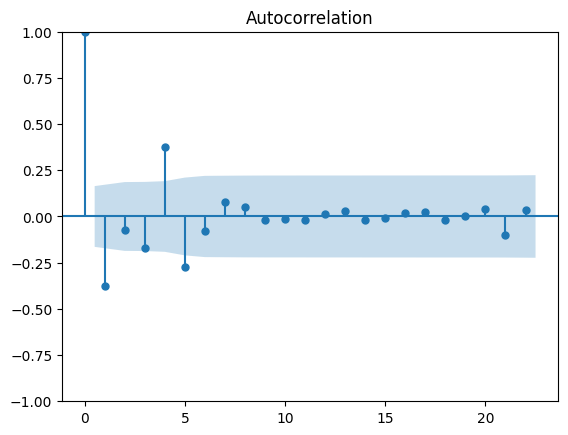

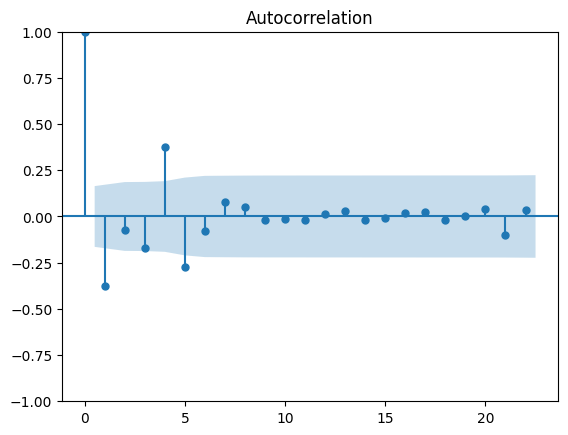

In [ ]:
# For illustrative purposes, select a single ts and watch the Autocorrelation and Partial autocorrelation functions, in order to have a general idea of the AR(p) and MA(q) parameters
n_store = 1
cond_1 = df_stores_sales["Store"] == n_store
list_ts = df_stores_sales.loc[cond_1, "Weekly_Sales_Diff"].tolist()[1:]

# Moving Average Lag Order (q)
#Autocorrelation function
sma.graphics.tsa.plot_acf(pd.DataFrame(list_ts))

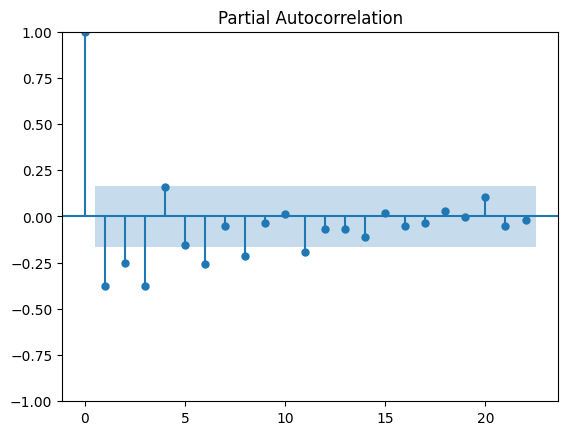

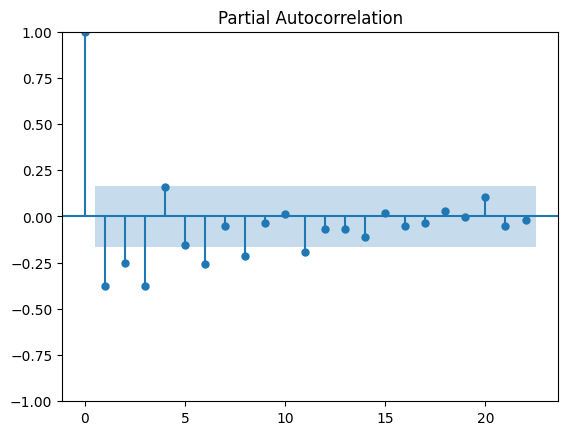

In [ ]:
# Auto-Regressive Lag Order (p)
#Partial autocorrelation function plot:
sma.graphics.tsa.plot_pacf(pd.DataFrame(list_ts))

In [ ]:
## -----------------------------------------------------------------------------
# Function to calculate AIC for different ARMA hyperparameters
def optimize_arma_aic(data, p_values, q_values):
    best_aic = float('inf')
    best_order = None
    results = []

    for p, q in itertools.product(p_values, q_values):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            aic = model.aic
            results.append((p, q, aic))

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)

        except Exception as e:
            continue

    results_df = pd.DataFrame(results, columns=['p', 'q', 'AIC']).sort_values(by='AIC')
    return best_order, results_df
## -----------------------------------------------------------------------------
# calculate the best P and Q parameters for each time series

# preallocate
df_best_order = pd.DataFrame()

# for each store
for n_store in df_stores_sales["Store"].unique().tolist():
  # select the time series
  cond_1 = df_stores_sales["Store"] == n_store
  list_ts = df_stores_sales.loc[cond_1, "Weekly_Sales_Diff"].tolist()[1:]
  # preallocate parameters
  p_values = range(0, 8)
  q_values = range(0, 8)
  # run te function
  best_order, results_df = optimize_arma_aic(list_ts, p_values, q_values)
  # store the outcomes
  df_results= pd.DataFrame({"Store":[n_store], "AR":[best_order[0]], "MA":[best_order[1]]})
  # concatenate
  df_best_order = pd.concat( [df_best_order, df_results])

# print
df_best_order

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



,Store,AR,MA
0,1,3,6
0,2,0,5
0,3,0,5
0,4,1,5
0,5,0,5
0,6,0,5
0,7,1,5
0,8,0,5
0,9,0,5
0,10,0,5


## fit & predict

In [ ]:
# preallocate
df_predictions = pd.DataFrame()
df_performances = pd.DataFrame()

# for each store, fit ARIMA, make predictions and calculate the errors
for n_store in df_stores_sales["Store"].unique().tolist():
  # select the time series
  sales_data = df_stores_sales[(df_stores_sales['Store'] == n_store)]
  # Split data into training and testing sets
  n_lenght = len(sales_data)
  n_threshold = 10
  train_data = sales_data["Weekly_Sales_Diff"].tolist()[1:(n_lenght-n_threshold)]
  test_data = sales_data["Weekly_Sales_Diff"].tolist()[(n_lenght-n_threshold):]
  # Fit the ARIMA model
  # (p, d, q) are the model parameters, you'll need to tune these
  # p: Autoregressive order
  # d: Differencing order
  # q: Moving Average order
  # detect the best parameters
  n_p = df_best_order.loc[(df_best_order["Store"] == n_store), "AR"].tolist()[0]
  n_q = df_best_order.loc[(df_best_order["Store"] == n_store), "MA"].tolist()[0]
  # fit ARIMA
  model = ARIMA(train_data, order=(n_p,0,n_q))
  model_fit = model.fit()
  # Make predictions
  predictions = model_fit.predict(start=len(train_data)+2, end=len(sales_data))
  # store predictions
  df_pred_store = pd.DataFrame ( {"Store":sales_data["Store"].tolist()[(n_lenght-n_threshold):],
                                  "Date": sales_data["Date"].tolist()[(n_lenght-n_threshold):],
                                  "actual":test_data,
                                  "predictions":predictions,
                                  })
  # concatenate predictions
  df_predictions = pd.concat([df_predictions, df_pred_store])
  # errors
  mse = mean_squared_error(test_data, predictions)
  rmse = root_mean_squared_error(test_data, predictions)
  mae = mean_absolute_error(test_data, predictions)
  df_perf_store = pd.DataFrame({"Store":[n_store], "MSE":[mse], "RMSE":[rmse], "MAE":[mae]  })
  df_performances = pd.concat([df_performances, df_perf_store])

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-inve

In [ ]:
# print the performances metrics
df_performances.head()

,Store,MSE,RMSE,MAE
0,1,1.429019e+10,119541.587670,99763.841659
0,2,9.461291e+09,97269.170210,68154.178511
0,3,6.222042e+08,24944.021127,19946.887280
0,4,9.246367e+09,96158.028844,74611.158266
0,5,4.715524e+08,21715.256905,16241.034601


## plot test_data vs. predictions

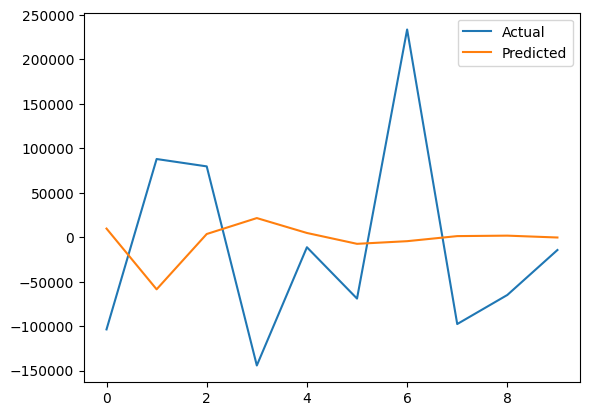

In [ ]:
# Plot the results
n_store = 1
cond_1 = df_predictions["Store"] == n_store
list_pred = df_predictions.loc[cond_1, "predictions"].tolist()
list_test = df_predictions.loc[cond_1, "actual"].tolist()

plt.plot(list_test, label='Actual')
plt.plot(list_pred, label='Predicted')
plt.legend()
plt.show()